In [1]:
!pip uninstall -y scikit-surprise
!pip install numpy==1.23.5
!pip install git+https://github.com/NicolasHug/Surprise.git


  Cloning https://github.com/NicolasHug/Surprise.git to /tmp/pip-req-build-p1x_sbjx
  Running command git clone --filter=blob:none --quiet https://github.com/NicolasHug/Surprise.git /tmp/pip-req-build-p1x_sbjx
  Resolved https://github.com/NicolasHug/Surprise.git to commit 2381fb11d0c4bf917cc4b9126f205d0013649966
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2469295 sha256=db5d4bde56621fe9b71765ab2133054f51c485f2c38dc5b205cd75fe2741b525
  Stored in directory: /tmp/pip-ephem-wheel-cache-ozt4je78/wheels/1f/bb/4c/85844f9fde8169beeaeeaf02a7b72cc8d562660b3c71aac715
Successfully built scikit-surprise


# PENINGKATAN AKURASI REKOMENDASI PRODUK E-COMMERCE MENGGUNAKAN HYBRID MODEL
disini saya hanya menghitung cbf dari produk unik agar ram yang digunakan lebih efisien sehingga meminimalisir terjadinya crash.

In [2]:
# install scikit-surprise dari github
!pip install git+https://github.com/NicolasHug/Surprise.git

  Cloning https://github.com/NicolasHug/Surprise.git to /tmp/pip-req-build-jdcf9bpq
  Running command git clone --filter=blob:none --quiet https://github.com/NicolasHug/Surprise.git /tmp/pip-req-build-jdcf9bpq
  Resolved https://github.com/NicolasHug/Surprise.git to commit 2381fb11d0c4bf917cc4b9126f205d0013649966
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
import warnings
warnings.filterwarnings('ignore')

In [4]:
# upload file data.csv manual dari laptop
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [5]:
# load dan pembersihan dataset
df = pd.read_csv('data.csv', encoding='ISO-8859-1')
df.dropna(subset=['CustomerID', 'Description'], inplace=True)
df = df[df['Quantity'] > 0]

In [6]:
# CBF (berdasarkan produk unik saja)
produk_unik = df[['StockCode', 'Description']].drop_duplicates().reset_index(drop=True)
produk_unik['Description'] = produk_unik['Description'].str.lower()

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(produk_unik['Description'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
indices = pd.Series(produk_unik.index, index=produk_unik['Description']).drop_duplicates()

def get_cbf_recommendations(product_name, top_n=5):
    idx = indices[product_name]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    product_indices = [i[0] for i in sim_scores]
    return produk_unik['Description'].iloc[product_indices].unique()

In [7]:
# collaborative filtering dengan surprise
cf_data = df.groupby(['CustomerID', 'StockCode'])['Quantity'].sum().reset_index()
cf_data.columns = ['userID', 'itemID', 'rating']

reader = Reader(rating_scale=(cf_data['rating'].min(), cf_data['rating'].max()))
data = Dataset.load_from_df(cf_data[['userID', 'itemID', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2)
svd = SVD()
svd.fit(trainset)
predictions = svd.test(testset)
accuracy.rmse(predictions)

RMSE: 80975.4493


80975.44925026514

In [9]:
# hybrid model (versi ringan)
def hybrid_recommend(user_id, product_name, alpha=0.5, top_n=5):
    product_ids = df['StockCode'].unique()
    cf_scores = {pid: svd.predict(user_id, pid).est for pid in product_ids}
    try:
        similar_products = get_cbf_recommendations(product_name, top_n=top_n*2)
        cbf_codes = produk_unik[produk_unik['Description'].isin(similar_products)]['StockCode']
        cbf_scores = df[df['StockCode'].isin(cbf_codes)]['StockCode'].value_counts(normalize=True).to_dict()
    except:
        cbf_scores = {}
    hybrid_scores = {}
    for pid in product_ids:
        cf_score = cf_scores.get(pid, 0)
        cbf_score = cbf_scores.get(pid, 0)
        hybrid_scores[pid] = alpha * cf_score + (1 - alpha) * cbf_score
    top_products = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    result = df[df['StockCode'].isin([p[0] for p in top_products])]['Description'].unique()
    return result

In [10]:
# contoh penggunaan hybrid
user_sample = str(cf_data['userID'].sample(1).values[0])
produk_sample = 'white metal lantern'
hybrid_recommend(user_sample, produk_sample, alpha=0.6, top_n=5)

array(['WHITE METAL LANTERN', 'HANGING METAL HEART LANTERN',
       'HANGING METAL STAR LANTERN', 'LANTERN CREAM GAZEBO ',
       'SET 6 PAPER TABLE LANTERN HEARTS ',
       'WHITE MOROCCAN METAL LANTERN'], dtype=object)

## evaluasi precision@k dan recall@k

In [11]:
from collections import defaultdict

def get_top_n(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = [iid for (iid, _) in user_ratings[:n]]
    return top_n

def precision_recall_at_k(predictions, k=5, threshold=0.5):
    top_n = get_top_n(predictions, n=k)
    hit = 0
    total_pred = 0
    total_rel = 0
    for uid, user_ratings in top_n.items():
        rel_items = [iid for (uid_, iid, true_r, est, _) in predictions if uid_ == uid and true_r >= threshold]
        hit += len(set(user_ratings) & set(rel_items))
        total_pred += len(user_ratings)
        total_rel += len(rel_items)
    precision = hit / total_pred if total_pred else 0
    recall = hit / total_rel if total_rel else 0
    return precision, recall

precision, recall = precision_recall_at_k(predictions, k=5, threshold=1)
print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")


Precision@5: 1.0000
Recall@5: 0.3175


## disini saya melakukan eksperimen variasi alpha pada hybrid model

In [12]:
alphas = [0.3, 0.5, 0.7]
hybrid_results = {}

for alpha in alphas:
    def hybrid_score(pid):
        cf_score = svd.predict(user_sample, pid).est
        cbf_score = 0
        try:
            similar_products = get_cbf_recommendations(produk_sample, top_n=10)
            cbf_codes = produk_unik[produk_unik['Description'].isin(similar_products)]['StockCode']
            cbf_score = 1.0 if pid in cbf_codes.values else 0
        except:
            pass
        return alpha * cf_score + (1 - alpha) * cbf_score

    scores = {pid: hybrid_score(pid) for pid in df['StockCode'].unique()}
    sorted_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:5]
    hybrid_results[alpha] = [df[df['StockCode'] == i[0]]['Description'].values[0] for i in sorted_items]

for alpha, items in hybrid_results.items():
    print(f"Alpha = {alpha} ➜ Top-5 Rekomendasi:")
    for item in items:
        print(" -", item)
    print()


Alpha = 0.3 ➜ Top-5 Rekomendasi:
 - WHITE METAL LANTERN
 - HANGING METAL HEART LANTERN
 - HANGING MEDINA LANTERN SMALL
 - WHITE LOVEBIRD LANTERN
 - HANGING METAL STAR LANTERN

Alpha = 0.5 ➜ Top-5 Rekomendasi:
 - WHITE METAL LANTERN
 - HANGING METAL HEART LANTERN
 - HANGING MEDINA LANTERN SMALL
 - WHITE LOVEBIRD LANTERN
 - HANGING METAL STAR LANTERN

Alpha = 0.7 ➜ Top-5 Rekomendasi:
 - WHITE METAL LANTERN
 - HANGING METAL HEART LANTERN
 - HANGING MEDINA LANTERN SMALL
 - WHITE LOVEBIRD LANTERN
 - HANGING METAL STAR LANTERN



## disini saya melakukan visualisasi perbandingan CF, CBF, dan hybrid

RMSE: 80975.4493


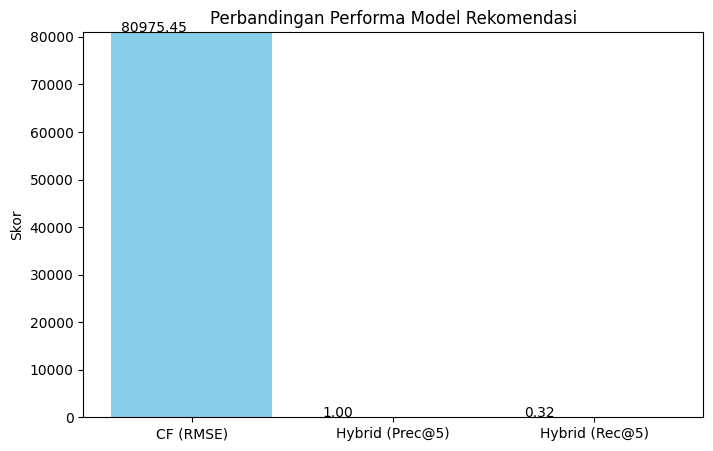

In [13]:
import matplotlib.pyplot as plt

models = ['CF (RMSE)', 'Hybrid (Prec@5)', 'Hybrid (Rec@5)']
values = [accuracy.rmse(predictions), precision, recall]

plt.figure(figsize=(8,5))
bars = plt.bar(models, values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title("Perbandingan Performa Model Rekomendasi")
plt.ylabel("Skor")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.05, yval + 0.01, f"{yval:.2f}")
plt.ylim(0, max(values)+0.2)
plt.show()


## analisis pola perilaku pengguna

🔝 Produk Terpopuler:
Description
WHITE HANGING HEART T-LIGHT HOLDER    2028
REGENCY CAKESTAND 3 TIER              1724
JUMBO BAG RED RETROSPOT               1618
ASSORTED COLOUR BIRD ORNAMENT         1408
PARTY BUNTING                         1397
LUNCH BAG RED RETROSPOT               1316
SET OF 3 CAKE TINS PANTRY DESIGN      1159
LUNCH BAG  BLACK SKULL.               1105
POSTAGE                               1099
PACK OF 72 RETROSPOT CAKE CASES       1068
Name: count, dtype: int64

🌍 Negara dengan Transaksi Terbanyak:
Country
United Kingdom    354345
Germany             9042
France              8342
EIRE                7238
Spain               2485
Name: count, dtype: int64


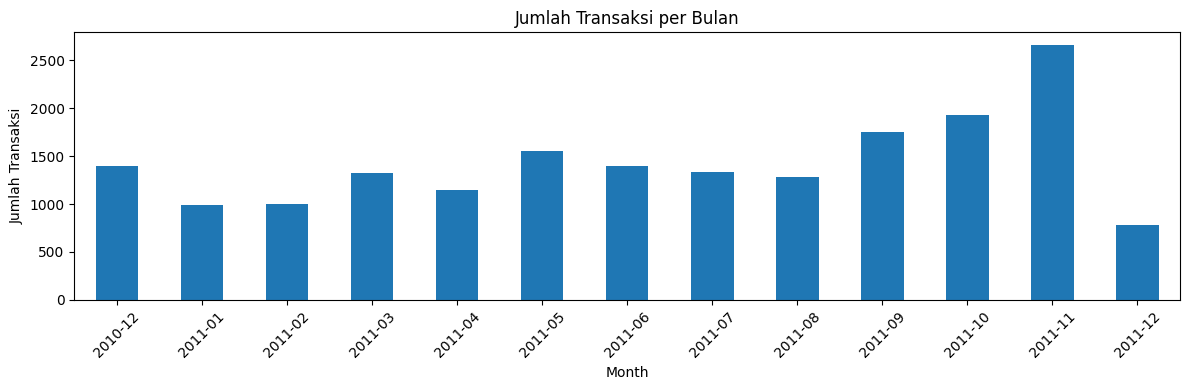

In [14]:
# produk paling populer
popular_products = df['Description'].value_counts().head(10)
print("🔝 Produk Terpopuler:")
print(popular_products)

# negara dengan transaksi terbanyak
top_countries = df['Country'].value_counts().head(5)
print("\n🌍 Negara dengan Transaksi Terbanyak:")
print(top_countries)

# frekuensi transaksi per bulan
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_orders = df.groupby('Month')['InvoiceNo'].nunique()

monthly_orders.plot(kind='bar', figsize=(12,4), title="Jumlah Transaksi per Bulan")
plt.ylabel("Jumlah Transaksi")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
